###Loading dataset

In [59]:
!curl -L -o 3d-mnist.zip https://www.kaggle.com/api/v1/datasets/download/daavoo/3d-mnist

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  152M  100  152M    0     0   117M      0  0:00:01  0:00:01 --:--:--  244M


In [60]:
!unzip /content/3d-mnist.zip

Archive:  /content/3d-mnist.zip
replace full_dataset_vectors.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [61]:
import h5py
import numpy as np


In [62]:
with h5py.File('full_dataset_vectors.h5', 'r') as dataset:
    X_train = dataset["X_train"][:]
    X_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

In [63]:
print ("x_train shape: ", X_train.shape)
print ("y_train shape: ", y_train.shape)
print ("x_test shape:  ", X_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


In [64]:
print(type(X_train))

<class 'numpy.ndarray'>


In [65]:
X_train = X_train.reshape(-1, 16, 16, 16)  # reshaping into 3D cloud
X_test = X_test.reshape(-1, 16, 16, 16)

In [67]:
with h5py.File("train_point_clouds.h5", "r") as f:
    for digit in list(f.keys())[:3]:
        print(f"Digit: {digit}")
        for attr in f[digit].attrs:
            print(f"  - {attr}: {f[digit].attrs[attr]}")

Digit: 0
  - label: 5
Digit: 1
  - label: 0
Digit: 10
  - label: 3


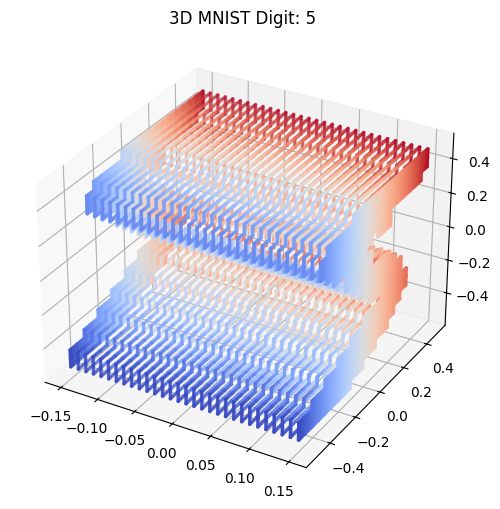

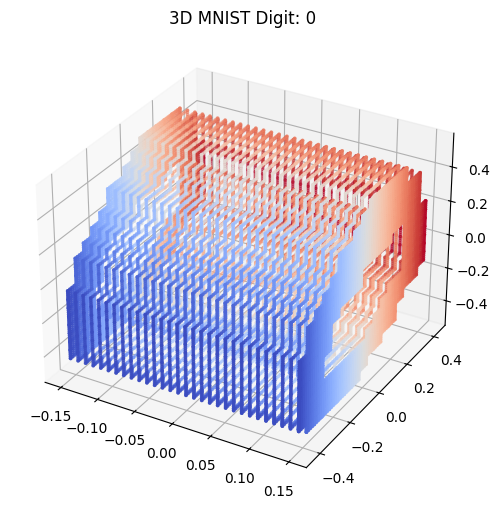

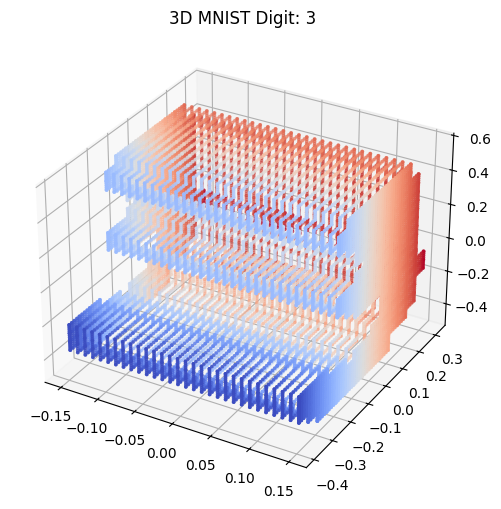

In [68]:
with h5py.File("train_point_clouds.h5", "r") as points_dataset:
    digits = list(points_dataset.keys())[:3]  # Get first 3 digits

    for digit in digits:
        points = points_dataset[digit]["points"][:]  # Extract 3D points
        label = points_dataset[digit].attrs["label"]  # Get digit label

        # Extract coordinates
        x, y, z = points[:, 0], points[:, 1], points[:, 2]


        fig = plt.figure(figsize=(6, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c=y, cmap='coolwarm', s=3)
        ax.set_title(f"3D MNIST Digit: {label}")

        plt.show()

# CNN Implementation

### Q1

In [70]:
def activation(x, actv, alpha = 0.1):  # set of activation functions
  if( actv == "relu"):
    x = np.maximum(0,x)
  elif(actv == "sigmoid"):
    x = 1/(1+np.exp(-x))
  elif(actv == "tanh"):
    x = (np.exp(x) - np.exp(-x)) / (np.exp(x)+ np.exp(-x))
  elif(actv =="leaky-relu"):
    x = np.where(x>0, x, alpha*x)
  return x

In [71]:
def pad(input, padding):
    C, D, H, W = input.shape
    padded_shape = (C, D + 2 * padding, H + 2 * padding, W + 2 * padding)  # shape after padding
    padded_input = np.zeros(padded_shape)
    padded_input[:, padding:padding + D, padding:padding + H, padding:padding + W] = input   # placing the input and zeros along the extra dimension
    return padded_input

In [72]:
def conv_single(input, kernel_size, stride=1, padding = 0, actv = None):
    if padding > 0:                              # if padding required or not
        input = pad(input, padding)

    C_in, d_in, h_in, w_in = input.shape
    k_d, k_h, k_w = kernel_size


    filter = np.random.randn(C_in, k_d, k_h, k_w)   #generating a kernel filter

    d_out = int((d_in - k_d) / stride) + 1
    h_out = int((h_in - k_h) / stride) + 1
    w_out = int((w_in - k_w) / stride) + 1

    output = np.zeros((d_out, h_out, w_out))   #dimension of output accoriding to calculated dimension

    for d in range(d_out):            #applying the filter through each region and convolution performed
        for h in range(h_out):
            for w in range(w_out):
                d_, h_, w_ = d * stride, h * stride, w * stride
                region = input[:, d_:d_+k_d, h_:h_+k_h, w_:w_+k_w]
                output[d, h, w] = np.sum(region * filter)

    if actv is not None:
        output = activation(output, actv)   #for single convolution operation

    return output, filter # Returning filter for visualisation

In [73]:
def visualisation(input, channel = 0):
  input_vis = input[channel]
  threshold_in = np.max(input_vis) * 0.2  # filtering points for better visualization
  coords_in = np.argwhere(input_vis > threshold_in)

  fig = plt.figure(figsize=(12, 6))

  # Plot one channel of input 3D point cloud
  ax1 = fig.add_subplot(121, projection='3d')
  ax1.scatter(coords_in[:, 0], coords_in[:, 1], coords_in[:, 2], c='b', marker='o')
  ax1.set_title(f'Input 3D Point Cloud (Channel {channel})')
  ax1.set_xlabel('Depth')
  ax1.set_ylabel('Height')
  ax1.set_zlabel('Width')
  plt.tight_layout()
  plt.show()




#### Applying convolution with relu

Input Shape (1, 16, 16, 16)


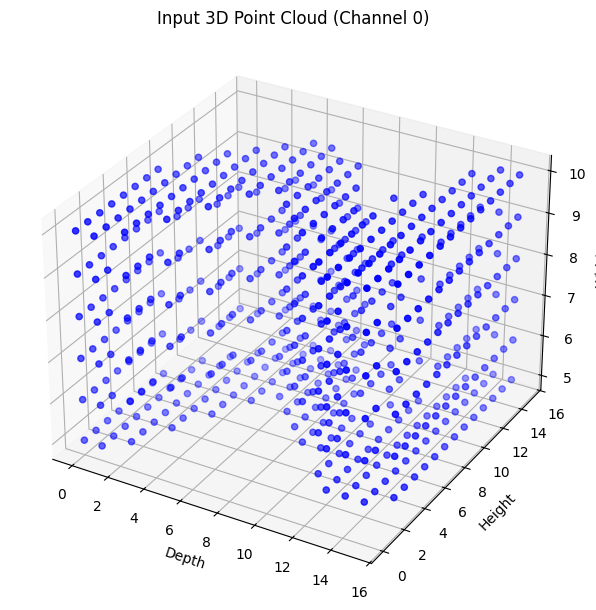

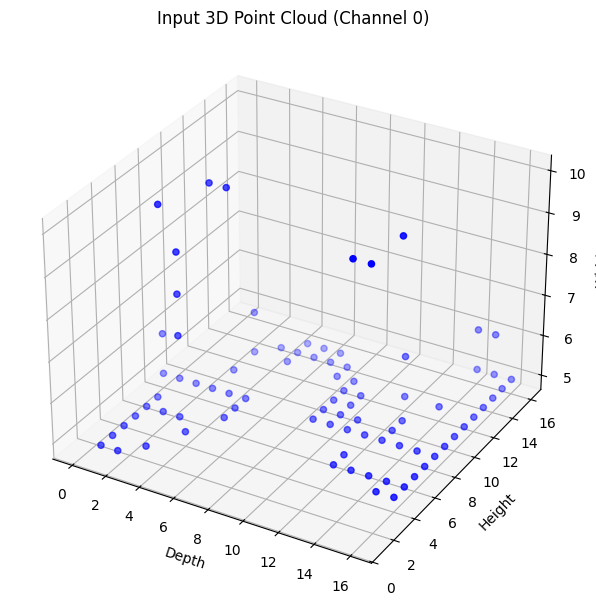

Output Shape (1, 17, 17, 17)


In [74]:
input_conv = X_train[0]
input_conv = input_conv.reshape((1,16,16,16)) # Adding channel as 4th dimension
print("Input Shape", input_conv.shape)
visualisation(input_conv)
output_conv, _ = conv_single(input_conv, kernel_size=(2,2,2), actv = "relu", stride=1, padding=1)
output_conv = output_conv.reshape((1, *output_conv.shape))
visualisation(output_conv)
print("Output Shape", output_conv.shape)

#### Applying convolution with tanh

Input Shape (1, 16, 16, 16)


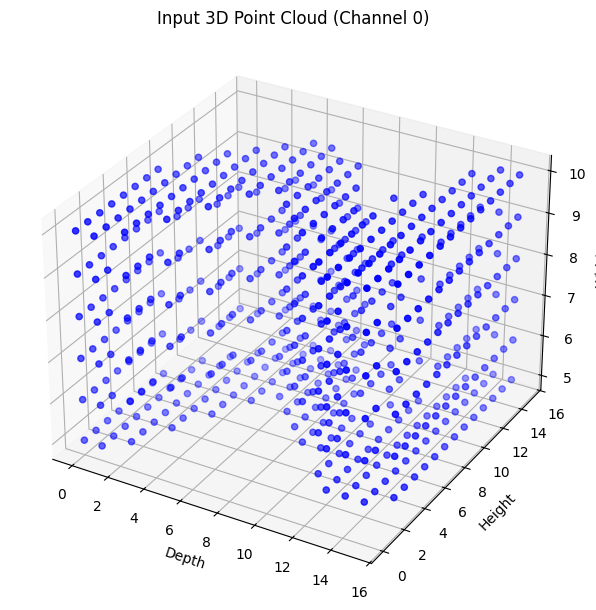

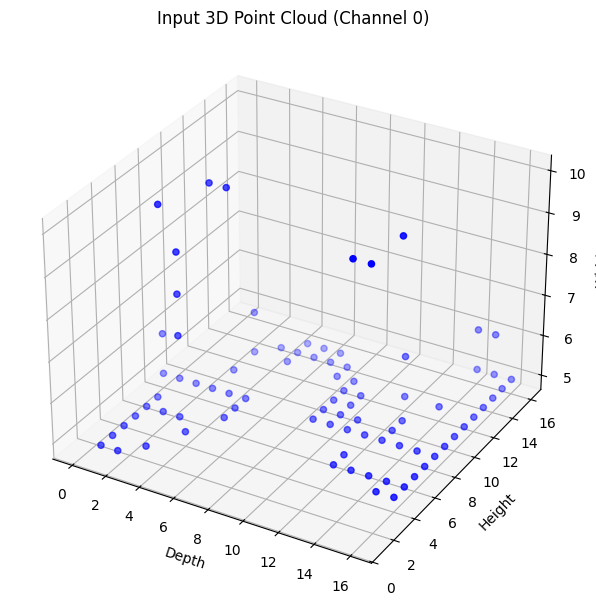

Output Shape (1, 17, 17, 17)


In [75]:
input_conv = X_train[0]
input_conv = input_conv.reshape((1,16,16,16))
print("Input Shape", input_conv.shape)
visualisation(input_conv)
output_conv1, _ = conv_single(input_conv, kernel_size=(2,2,2), actv = "tanh", stride=1, padding=1)
output_conv1 = output_conv1.reshape((1, *output_conv1.shape))
visualisation(output_conv)
print("Output Shape", output_conv.shape)

#### Applying convolution with sigmoid

Input Shape (1, 16, 16, 16)


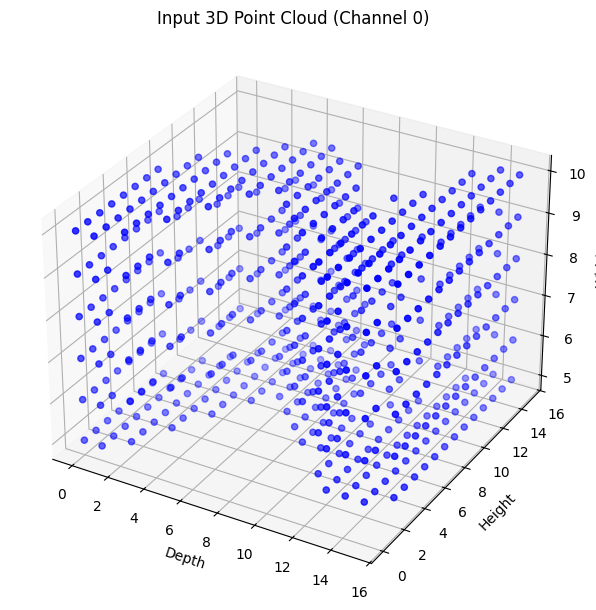

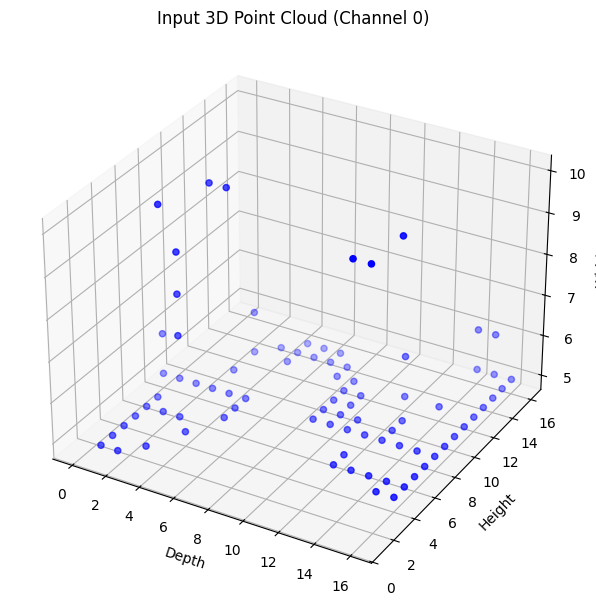

Output Shape (1, 17, 17, 17)


In [76]:
input_conv = X_train[0]
input_conv = input_conv.reshape((1,16,16,16))
print("Input Shape", input_conv.shape)
visualisation(input_conv)
output_conv1, _ = conv_single(input_conv, kernel_size=(2,2,2), actv = "sigmoid", stride=1, padding=1)
output_conv1 = output_conv1.reshape((1, *output_conv1.shape))
visualisation(output_conv)
print("Output Shape", output_conv.shape)

#### Applying conv with relu

Input Shape (1, 16, 16, 16)


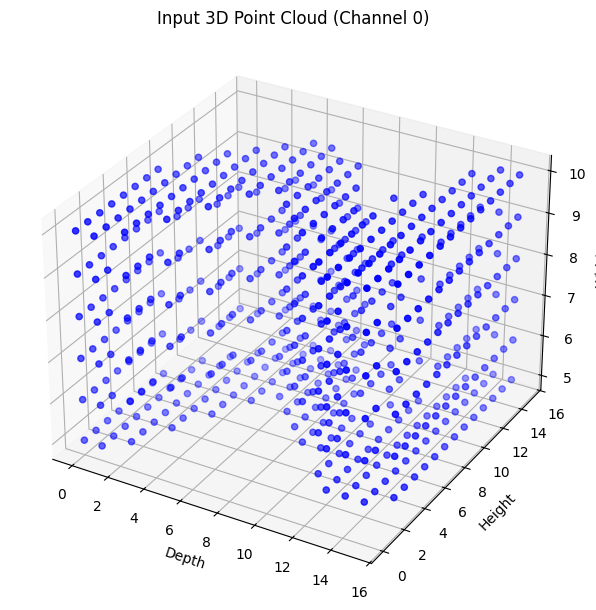

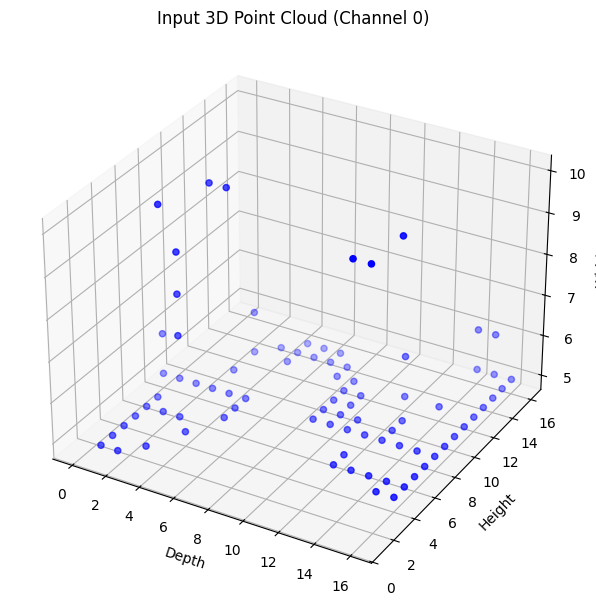

Output Shape (1, 17, 17, 17)


In [77]:
input_conv = X_train[0]
input_conv = input_conv.reshape((1,16,16,16))
print("Input Shape", input_conv.shape)
visualisation(input_conv)
output_conv1, _ = conv_single(input_conv, kernel_size=(2,2,2), actv = "relu", stride=1, padding=1)
output_conv1 = output_conv1.reshape((1, *output_conv1.shape))
visualisation(output_conv)
print("Output Shape", output_conv.shape)

#### Applying conv with leaky relu

Input Shape (1, 16, 16, 16)


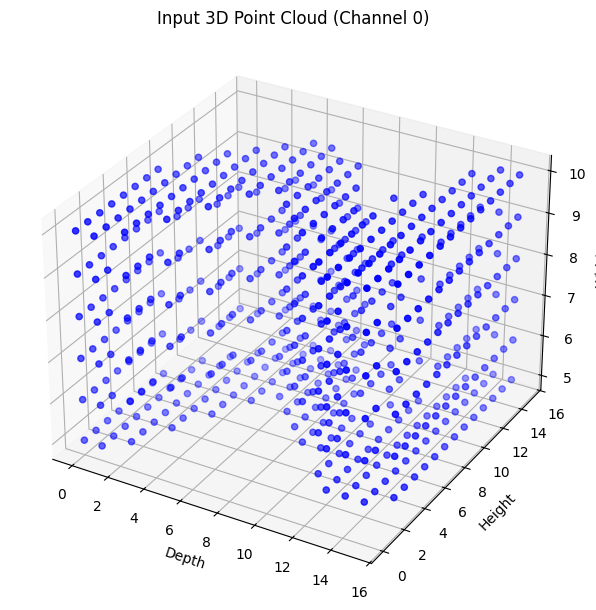

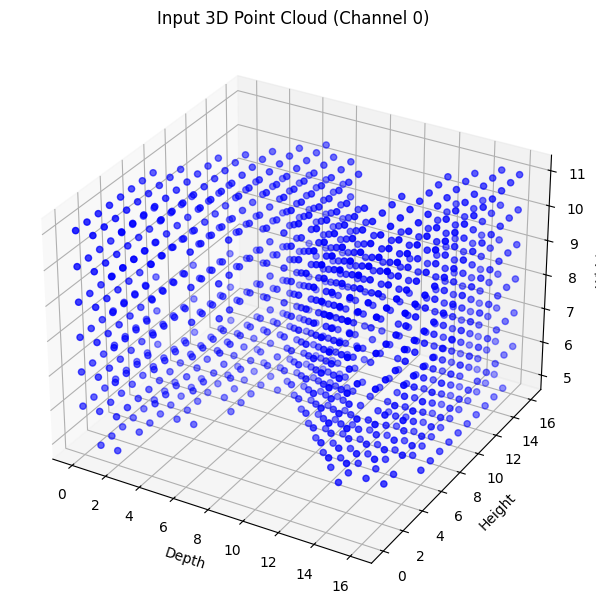

Output Shape (1, 17, 17, 17)


In [78]:
input_conv = X_train[0]
input_conv = input_conv.reshape((1,16,16,16))
print("Input Shape", input_conv.shape)
visualisation(input_conv)
output_conv1,_ = conv_single(input_conv, kernel_size=(2,2,2), actv = "leaky-relu", stride=1, padding=1)
output_conv1 = output_conv1.reshape((1, *output_conv1.shape))
visualisation(output_conv1)
print("Output Shape", output_conv1.shape)

### Q2

In [79]:
def pooling(input, pool_size =(2,2,2), stride =2, pool_type = 'max'):
  C, d_in, h_in, w_in = input.shape
  # calculate the new output dimensions
  d_out = int((d_in - pool_size[0])/ stride) +1
  h_out = int((h_in - pool_size[1])/ stride) +1
  w_out = int((w_in - pool_size[2])/stride) +1
  output = np.zeros((C, d_out, h_out, w_out))

  for c in range(C):
    for d in range(d_out):
      for h in range(h_out):
        for w in range(w_out):
          d_, h_, w_ = d* stride, h* stride, w*stride
          area = input[c, d_:d_+pool_size[0], h_:h_+pool_size[1], w_:w_+pool_size[2]]   # gather regions/patch and apply max or avg pooling acroos them
          output[c, d, h,w] = np.max(area) if pool_type == "max" else np.mean(area)

  return output

#### Max pooling

Input Shape (1, 17, 17, 17)


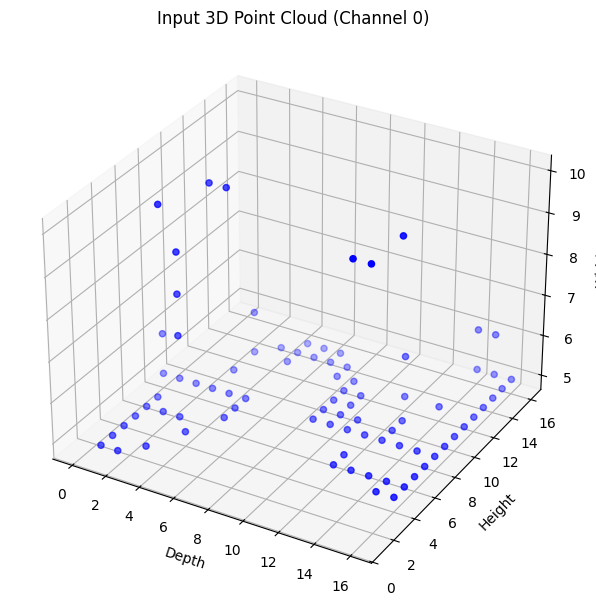

Output Shape (1, 8, 8, 8)


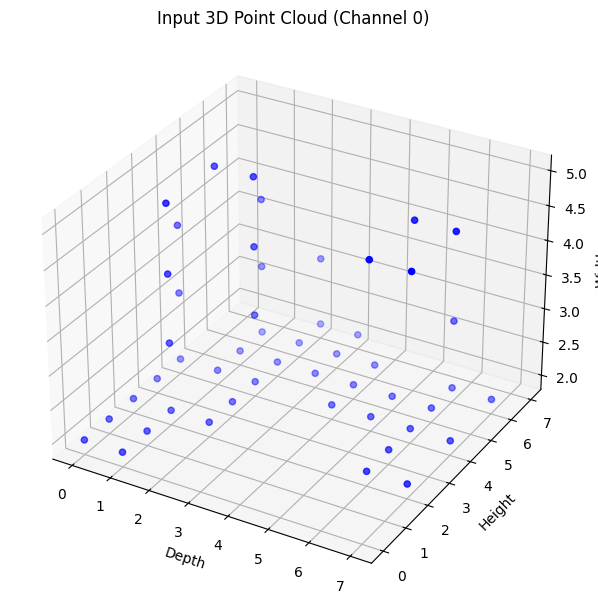

In [80]:
input_pool = output_conv
# input_pool = output_conv.reshape((1, *output_conv.shape))
print("Input Shape", input_pool.shape)
visualisation(input_pool)
output_pool = pooling(input_pool, pool_size =(2,2,2), stride =2, pool_type = 'max')
print("Output Shape", output_pool.shape)
visualisation(output_pool)

#### Avg pooling

Input Shape (1, 17, 17, 17)


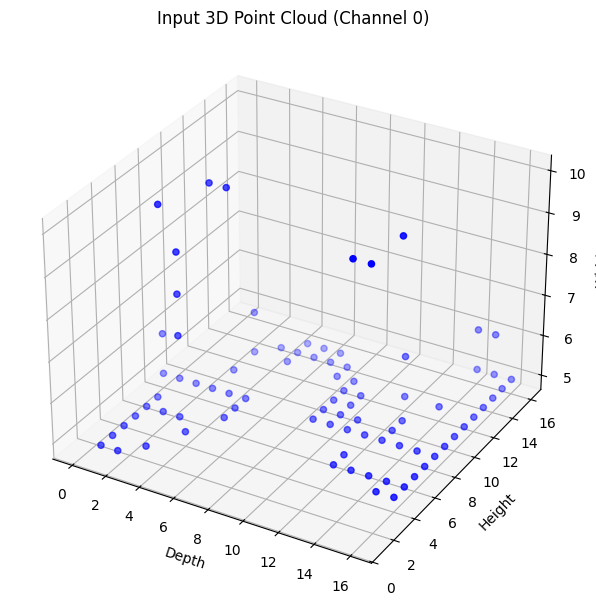

Output Shape (1, 8, 8, 8)


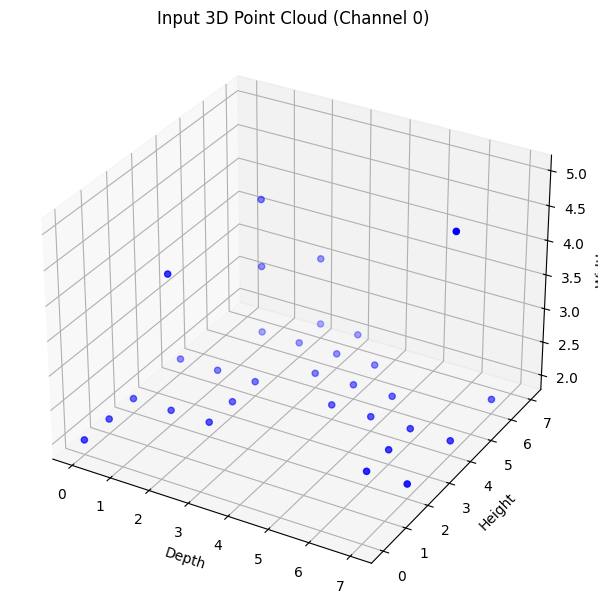

In [81]:
input_pool1 = output_conv
print("Input Shape", input_pool1.shape)
visualisation(input_pool)
output_pool1 = pooling(input_pool1, pool_size =(2,2,2), stride =2, pool_type = 'avg')
print("Output Shape", output_pool1.shape)
visualisation(output_pool1)

### Q3

In [82]:
def conv_multi(input, num_filters=3, kernel_size=(3,3,3), stride=1, padding=0, actv='relu'):
    C_in, d_in, h_in, w_in = input.shape
    k_d, k_h, k_w = kernel_size


    if padding > 0:
        input = pad(input, padding)     # padding if needed

    d_out = int((d_in + 2 * padding - k_d) / stride) + 1
    h_out = int((h_in + 2 * padding - k_h) / stride) + 1   # calulate output dimension
    w_out = int((w_in + 2 * padding - k_w) / stride) + 1

    output = np.zeros((num_filters, d_out, h_out, w_out))   #4D output
    filters = []

    for f in range(num_filters):
        output[f], filter = conv_single(input, kernel_size, stride=stride)  # take each filterr and apply conv on input and append the feature map
        filters.append(filter)                                              # n filters give n output maps

    output = activation(output, actv)

    return output, filters


In [83]:
def visualize_4d_tensor(input_tensor, filters):   # plot the 4D as subplots
    fig = plt.figure(figsize=(12, 8))

    for i in range(3):
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        input_vis = input_tensor[i]
        threshold = np.max(input_vis) * 0.2
        coords = np.argwhere(input_vis > threshold)
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='b', marker='o')
        ax.set_title(f'Input Channel {i+1}')    # 3D plot along each channel
        ax.set_xlabel('Depth')
        ax.set_ylabel('Height')
        ax.set_zlabel('Width')

    for i in range(3):
        ax = fig.add_subplot(2, 3, i + 4)
        ax.imshow(filters[i][0].mean(axis=0), cmap='gray') # Filters matrices (2x2) as gray colour maps for visualisation
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Apply relu on multi filter conv

Input Shape: (1, 16, 16, 16)


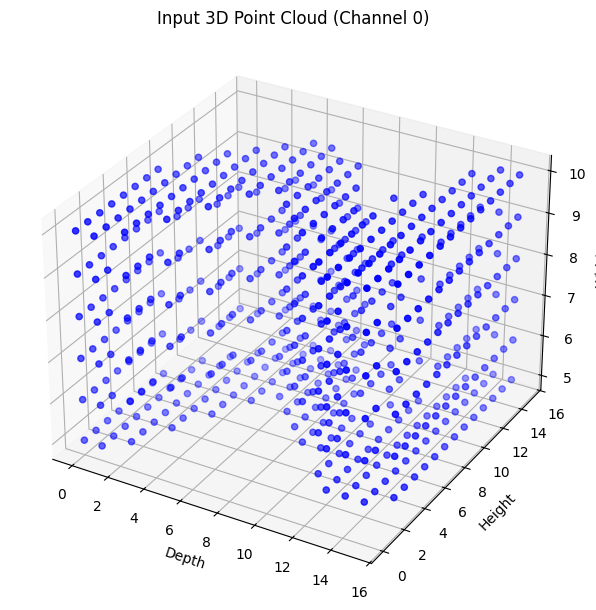

Filter Shape: (1, 2, 2, 2)
Output Shape: (3, 17, 17, 17)


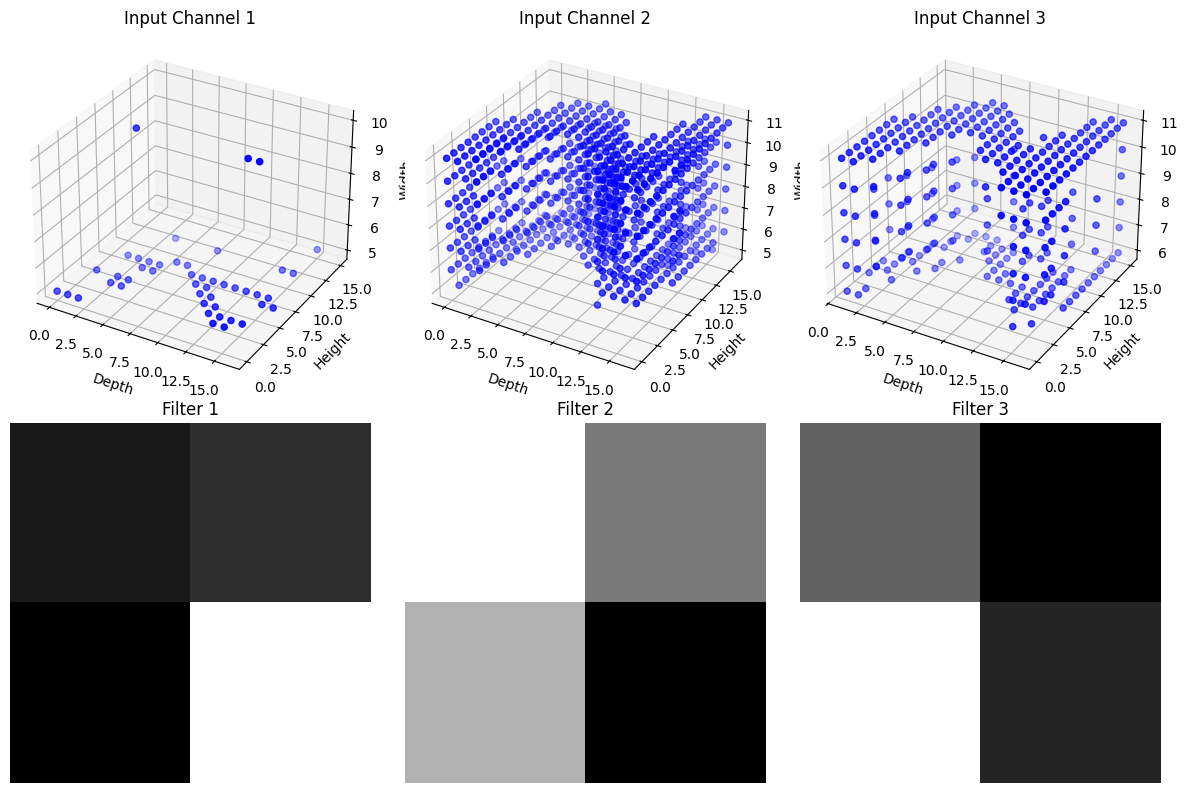

In [84]:
input_conv = X_train[0]
input_conv = input_conv.reshape((1,16,16,16))
print("Input Shape:", input_conv.shape)
visualisation(input_conv)
output_conv, filters = conv_multi(input_conv, kernel_size=(2,2,2), actv = "relu", stride=1, padding=1)
print("Filter Shape:",filters[0].shape)
print("Output Shape:",output_conv.shape)
visualize_4d_tensor(output_conv, filters)

### Q4

In [85]:
def pooling_multi(input, stride = 2, pool_type = 'max', pool_size =(2,2,2)):   #multi layer pooling
  C, d_in, h_in, w_in = input.shape
  if pool_type == 'gap':                 # if gap then flatten the vector along 3 axis
    output = np.mean(input, axis =(1,2,3), keepdims = True)
    return output

  d_out = int((d_in - pool_size[0])/stride) +1
  h_out = int((h_in - pool_size[1])/stride) +1
  w_out = int((w_in - pool_size[2])/stride) +1
  output = np.zeros((C, d_out, h_out, w_out))   # output dimensions

  for c in range(C):
    for d in range(d_out):
      for h in range(h_out):
        for w in range(w_out):
          d_, h_, w_ = d* stride, h* stride, w* stride
          area = input[c, d_:d_+pool_size[0] , h_:h_+pool_size[1], w_:w_+pool_size[2]]  # applying max or avg pooling across each region
          output[c,d,h,w] = np.max(area) if pool_type == "max" else np.mean(area)

  return output

#### Pooling layer func- average pooling

Input Shape: (3, 17, 17, 17)
Output Shape: (3, 8, 8, 8)


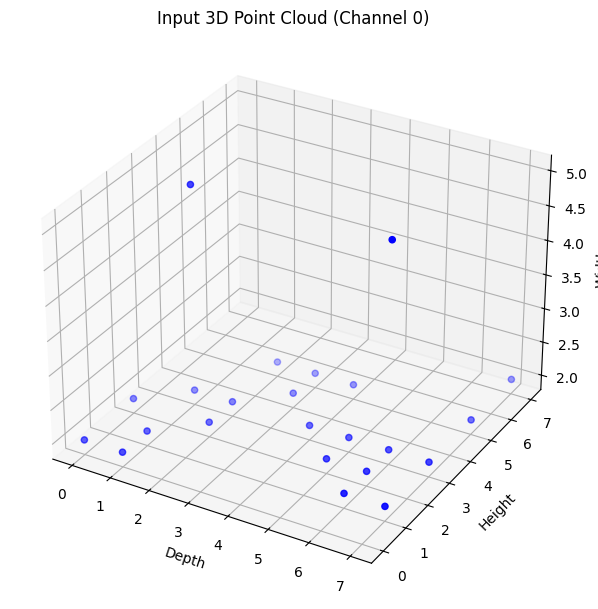

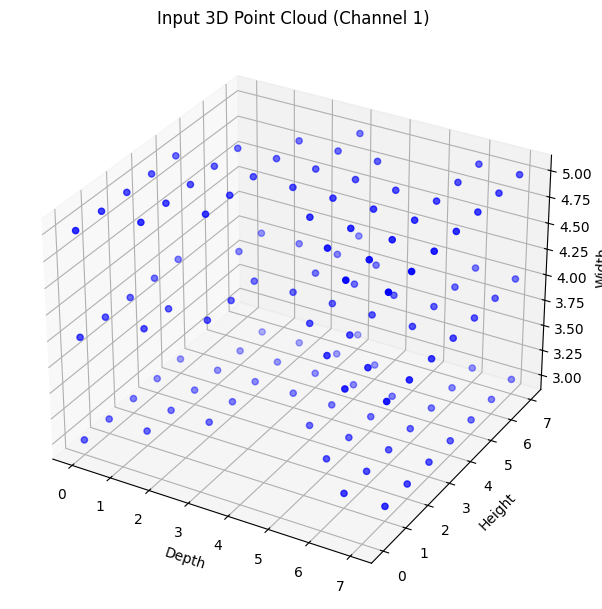

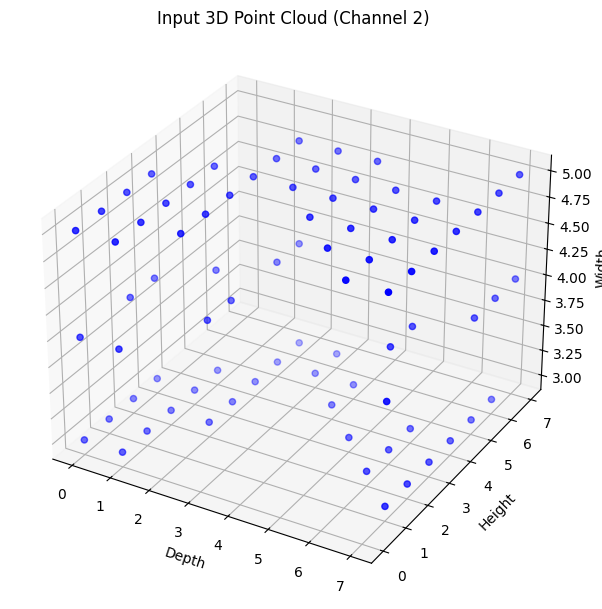

In [86]:
output_conv
print("Input Shape:", output_conv.shape)
output_pooling = pooling_multi(output_conv, 2, 'mean', (2,2,2))
print("Output Shape:", output_pooling.shape)
# Visualize each channel
visualisation(output_pooling, 0)
visualisation(output_pooling, 1)
visualisation(output_pooling, 2)

#### Pooling layer function- max pooling

Input Shape: (3, 17, 17, 17)
Output Shape: (3, 8, 8, 8)


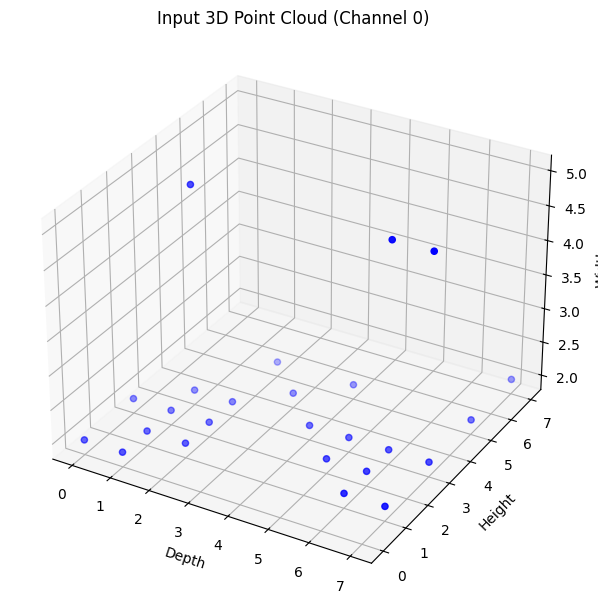

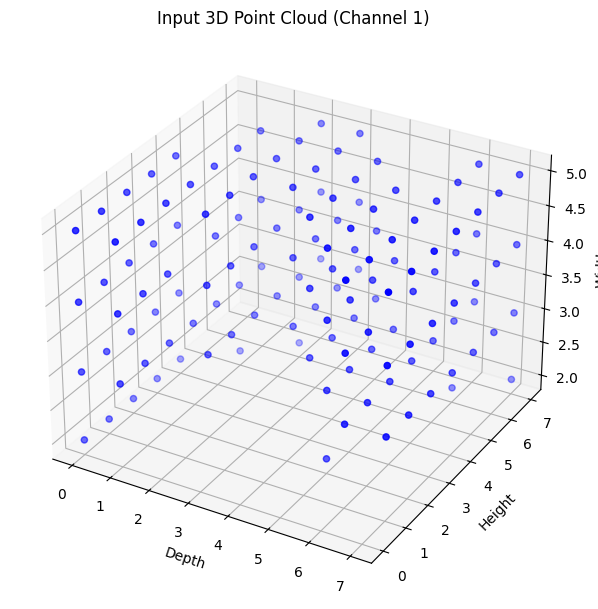

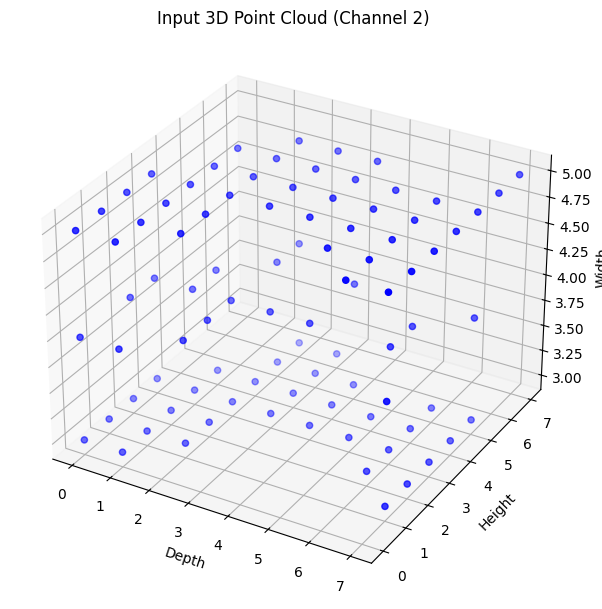

In [87]:
output_conv
print("Input Shape:", output_conv.shape)
output_pooling = pooling_multi(output_conv, 2, 'max', (2,2,2))
print("Output Shape:", output_pooling.shape)
visualisation(output_pooling, 0)
visualisation(output_pooling, 1)
visualisation(output_pooling, 2)

#### Applying gap

In [88]:
output_conv
output_pooling = pooling_multi(output_conv, 2, 'gap', (2,2,2)) # Flattens the output
output_pooling.shape, output_pooling

((3, 1, 1, 1),
 array([[[[0.0092007 ]]],
 
 
        [[[0.23001617]]],
 
 
        [[[0.03234459]]]]))

### Q5

In [89]:
def mlp(input, hidden_layer= [32,16], actv = 'relu'):
  x = input
  for layer in hidden_layer:    # multilple hidden layers
    weights = np.random.randn(x.shape[-1], layer) *0.01
    bias = np.random.randn(layer) *0.01
    y = np.dot(x,weights) + bias # y = W.T * x + b
    x = activation(y, actv)   # forward pass
  weights = np.random.randn(x.shape[-1],10) *0.01
  bias = np.random.randn(10)*0.01
  y = np.dot(x,weights) + bias
  return activation(y, 'softmax') # Probability among the output classes

### Q6

#### combining all parts as a block

In [90]:
def cnn(input):
  print("Input Shape:", input.shape)
  x, _ = conv_multi(input, num_filters = 16, kernel_size=(5,5,5), actv= "relu", stride =1, padding = 0)
  print("Block 1 Conv:", x.shape)
  x = pooling(x, pool_size =(2,2,2), stride =2, pool_type = 'max')
  print("Block 2 Max Pooling:", x.shape)
  x, _ = conv_multi(x, num_filters=32, kernel_size=(3,3,3), stride =1, padding =0, actv = 'relu')
  print("Block 3 CNN Multi layer:", x.shape)
  x = pooling_multi(x, stride = 2, pool_type = 'max', pool_size =(2,2,2))
  print("Block 4 Max pooling:", x.shape)
  x = pooling_multi(x, pool_type = 'gap').reshape(1,-1)
  print("Global Average pooling:", x.shape)
  output = mlp(x, hidden_layer=[64], actv='relu')
  print("Output shape",output.shape)
  return output

In [91]:
input = X_train[0]
cnn(input.reshape((1,*input.shape))) # Output's probability according to the output classes

Input Shape: (1, 16, 16, 16)
Block 1 Conv: (16, 12, 12, 12)
Block 2 Max Pooling: (16, 6, 6, 6)
Block 3 CNN Multi layer: (32, 4, 4, 4)
Block 4 Max pooling: (32, 2, 2, 2)
Global Average pooling: (1, 32)
Output shape (1, 10)


array([[ 0.55567546, -0.40900498,  0.27596868, -0.46074563,  0.24616001,
        -0.17832929,  0.0828735 , -0.6764451 ,  0.25351003, -0.36603184]])

# Sequence model

In [92]:
import torch
torch.manual_seed(0)

###### Download code from Repo

In [93]:
!git clone https://github.com/TheAlgorithms/C-Plus-Plus

fatal: destination path 'C-Plus-Plus' already exists and is not an empty directory.


In [94]:
!git clone https://github.com/fragglet/c-algorithms

fatal: destination path 'c-algorithms' already exists and is not an empty directory.


In [95]:
!git clone https://github.com/chenjinxian/CLRS

fatal: destination path 'CLRS' already exists and is not an empty directory.


In [96]:
import os
import random
import csv

random.seed(0)

BRACKET_MAP = {')': '(', '}': '{', ']': '[', '>': '<'}
opening = set(BRACKET_MAP.values())
closing = set(BRACKET_MAP.keys())

def count_bracket(seq):    # count the number of matching pairs of brackets.
  stack =[] # stack implementation
  count =0
  for ch in seq:
    if ch in opening:
      stack.append(ch)
    elif ch in closing:
      if stack and stack[-1] == BRACKET_MAP[ch]:
        stack.pop()
        count+= 1
  return count

def merge_repos(repo_dirs, out_file):
  extension = {'.cpp','.h','.hpp','.c'}
  with open(out_file, 'w', encoding='utf-8') as outfile:   #selectively read files and write to another file
    for repo in repo_dirs:
      for root, dirs, files in os.walk(repo):
        for file in files:
          if os.path.splitext(file)[1] in extension:
            try:
              with open(os.path.join(root, file), 'r', encoding ='utf-8', errors='ignore')as infile:
                outfile.write(infile.read())
                outfile.write('\n')
            except Exception as e:
              print(f'Couldnt read {file} : {e}')


def sample_seq(text, num_samples=7000, min_len =50, max_len=200):   # create samples of different length - Training - 5600 Testing - Rest
  dataset =[]
  text_len = len(text)
  for i in range(num_samples):
    start = random.randint(0, max(0, text_len- min_len))
    length = random.randint(min_len, max_len)
    end = start + length if (start + length) < text_len else text_len # find start index and end index and create snippets
    snippet = huge_text[start:end]
    label = count_bracket(snippet)
    dataset.append((snippet, label))
  return dataset



repos = ["/content/C-Plus-Plus", "/content/CLRS", "/content/c-algorithms"]
merge_repos(repos, "merged_code.txt")

with open("merged_code.txt", "r", encoding ='utf-8', errors= 'ignore') as f:
  huge_text = f.read()

dataset = sample_seq(huge_text.replace("\n", ""), num_samples=7000, min_len =50, max_len=100)

with open("balanced_brackets_dataset.csv",'w', newline='', encoding='utf-8') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(["X","y"])         # create csv file with smaples as X and their bracket counts as Y
  for snippet, label in dataset:
    writer.writerow([snippet, label])

print("Dataset creation complete. Saved to balanced_brackets_datset.csv")

Dataset creation complete. Saved to balanced_brackets_datset.csv


In [97]:
import csv
import random
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
def load_data(csv_file): # load data from csv file
  data = []
  with open(csv_file, 'r', encoding ='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
      data.append((row['X'], int(row['y'])))

  return data

In [98]:
def build_vocabulary(data):
  vocab = set()
  for snippet, _ in data:
    vocab.update(snippet)
  vocab = sorted(list(vocab))   # create sorted list of all unique characters
  vocab = ['<PAD>'] + vocab     # <PAD> Special character for padding length less than maximum length
  char_to_ind = {ch: ind for ind, ch in enumerate(vocab)}  # create mapping of char to ind
  ind_to_char = {ind: ch for ind , ch in enumerate(vocab)} # create reverse - mapping of ind to char
  return vocab, char_to_ind, ind_to_char

In [99]:
def encode_data(data, char_to_ind):  # based on char_to_ind encode each char and create encoded data
  encoded_data = []
  for snippet, label in data:
    encoded = [char_to_ind[ch] for ch in snippet if ch in char_to_ind]
    encoded_data.append((encoded, label))
  return encoded_data

In [100]:
def get_batches(encoded_data, batch_size, shuffle = True):
  if shuffle:
    random.shuffle(encoded_data)
  batches = []
  for i in range(0, len(encoded_data), batch_size):   # from encoded data create batches
    batch = encoded_data[i: i+batch_size]
    max_len = max(len(seq) for seq, _ in batch)
    batch_inputs, batch_lengths, batch_targets = [], [], []
    for seq, label in batch:
      batch_lengths.append(len(seq))
      padded = seq + [0]*(max_len-len(seq)) # pad (<PAD>) input if it doesnt match length
      batch_inputs.append(padded)
      batch_targets.append(label)   # extract target label
    batch_inputs = torch.tensor(batch_inputs, dtype = torch.long)
    batch_lengths = torch.tensor(batch_lengths, dtype = torch.long)
    batch_targets = torch.tensor(batch_targets, dtype = torch.float)
    batches.append((batch_inputs, batch_lengths, batch_targets))
  return batches

##### Elmon RNN

In [ ]:
class ElmonRNN:
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    # Embedding Block
    self.E = torch.randn(vocab_size, embedding_dim) * 0.01
    # Lower weight to avoid weight explotion - would have resulted in nan Losses
    self.E.requires_grad = True

    #initialise weights
    self.Wxh = torch.randn(embedding_dim, hidden_dim) *0.01
    self.Wxh.requires_grad = True
    self.Whh = torch.randn(hidden_dim, hidden_dim) *0.01
    self.Whh.requires_grad = True
    self.bh = torch.zeros(hidden_dim)
    self.bh.requires_grad = True

    self.Why = torch.randn(hidden_dim, output_dim)*0.01
    self.Why.requires_grad = True
    self.by = torch.zeros(output_dim)
    self.by.requires_grad = True
    self.params = [self.E, self.Wxh, self.Whh, self.bh, self.Why, self.by]

  def forward(self, inputs, lengths):
    batch_size , seq_len = inputs.shape
    embedded = self.E[inputs]
    h = torch.zeros(batch_size, self.hidden_dim)
    for t in range(seq_len):
      xt = embedded[:,t,:]
      h = xt @ self.Wxh + h @ self.Whh + self.bh
      x_clipped = torch.clamp(h, min=-10000000000, max=10000000000) # perform clamping to avoid nan value in losses
      # tanh using exp
      h = (torch.exp(x_clipped) - torch.exp(-x_clipped)) / (torch.exp(x_clipped)+ torch.exp(-x_clipped))
    out = h @ self.Why + self.by
    return out

  def parameters(self):
    return self.params

##### LSTM

In [102]:
class LSTM:
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    # Embedding Block
    self.E = torch.randn(vocab_size, embedding_dim)*0.01
    self.E.requires_grad = True
    # initialise input gate
    self.Wxi = torch.randn(embedding_dim, hidden_dim)*0.01
    self.Wxi.requires_grad = True
    self.Whi = torch.randn(hidden_dim, hidden_dim)*0.01
    self.Whi.requires_grad = True
    self.bi = torch.randn(hidden_dim)*0.01
    self.bi.requires_grad =True
    #initialise forget gate
    self.Wxf = torch.randn(embedding_dim, hidden_dim)*0.01
    self.Wxf.requires_grad = True
    self.Whf = torch.randn(hidden_dim, hidden_dim)*0.01
    self.Whf.requires_grad = True
    self.bf = torch.randn(hidden_dim)*0.01
    self.bf.requires_grad = True
    #initialise output gate
    self.Wxo = torch.randn(embedding_dim, hidden_dim)*0.01
    self.Wxo.requires_grad = True
    self.Who = torch.randn(hidden_dim, hidden_dim)*0.01
    self.Who.requires_grad = True
    self.bo = torch.randn(hidden_dim)*0.01
    self.bo.requires_grad = True
    #initialise cell state
    self.Wxc_ = torch.randn(embedding_dim, hidden_dim)*0.01
    self.Wxc_.requires_grad = True
    self.Whc_ = torch.randn(hidden_dim, hidden_dim)*0.01
    self.Whc_.requires_grad = True
    self.bc_ = torch.randn(hidden_dim)*0.01
    self.bc_.requires_grad = True

    self.Why = torch.randn(hidden_dim, output_dim)*0.01
    self.Why.requires_grad = True
    self.by = torch.randn(output_dim)*0.01
    self.by.requires_grad = True
    self.params = [self.E, self.Wxi, self.Whi, self.bi, self.Wxf, self.Whf,
                  self.bf, self.Wxo, self.Who, self.bo, self.Wxc_,
                   self.Whc_, self.bc_, self.Why, self.by]

  def forward(self, inputs, lengths):
    def sigmoid(x): # custom sigmoid
      x_clipped = torch.clamp(x, min=-10000000000, max=10000000000)
      return 1/(1+torch.exp(-x_clipped))


    def tanh(x): # custom tanh
      x_clipped = torch.clamp(x, min=-10000000000, max=10000000000)
      return (torch.exp(x_clipped) - torch.exp(-x_clipped)) / (torch.exp(x_clipped)+ torch.exp(-x_clipped))


    batch_size, seq_len = inputs.shape
    embedded = self.E[inputs]
    h = torch.zeros(batch_size, self.hidden_dim)
    c = torch.zeros(batch_size, self.hidden_dim)
    for t in range(seq_len):
      xt = embedded[:,t,:]
      i_t = sigmoid(xt @ self.Wxi + h @ self.Whi + self.bi)   # apply lstm eqns on each t
      f_t = sigmoid(xt @ self.Wxf + h @ self.Whf + self.bf)
      o_t = sigmoid(xt @ self.Wxo + h @ self.Who + self.bo)
      c_ = tanh(xt @ self.Wxc_ + h @ self.Whc_ + self.bc_)
      c = f_t * c + i_t * c_
      h = o_t * tanh(c)
    out = h @ self.Why + self.by
    return out

  def parameters(self):
    return self.params

##### GRU

In [103]:
class GRU:
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.E = torch.randn(vocab_size, embedding_dim)*0.01
    self.E.requires_grad=True
    # r gate initialistion
    self.Wxr = torch.randn(embedding_dim, hidden_dim)*0.01
    self.Wxr.requires_grad=True
    self.Whr = torch.randn(hidden_dim, hidden_dim)*0.01
    self.Whr.requires_grad=True
    self.br  = torch.randn(hidden_dim)*0.01
    self.br.requires_grad=True
    # z gate initialisation
    self.Wxz = torch.randn(embedding_dim, hidden_dim)*0.01
    self.Wxz.requires_grad=True
    self.Whz = torch.randn(hidden_dim, hidden_dim)*0.01
    self.Whz.requires_grad=True
    self.bz  = torch.randn(hidden_dim)*0.01
    self.bz.requires_grad=True
    # initialising hidden
    self.Wxh = torch.randn(embedding_dim, hidden_dim)*0.01
    self.Wxh.requires_grad=True
    self.Whh = torch.randn(hidden_dim, hidden_dim)*0.01
    self.Whh.requires_grad=True
    self.bh  = torch.randn(hidden_dim)*0.01
    self.bh.requires_grad=True
    # Output layer.
    self.Why = torch.randn(hidden_dim, output_dim)*0.01
    self.Why.requires_grad=True
    self.by  = torch.randn(output_dim)*0.01
    self.by.requires_grad=True
    self.params = [self.E,
                       self.Wxr, self.Whr, self.br,
                       self.Wxz, self.Whz, self.bz,
                       self.Wxh, self.Whh, self.bh,
                       self.Why, self.by]
  def sigmoid(self, x): # custom sigmoid
    x_clipped = torch.clamp(x, min=-10000000000, max=10000000000)
    return 1/(1+torch.exp(-x_clipped))

  def tanh(self, x): # custom tanh
    x_clipped = torch.clamp(x, min=-10000000000, max=10000000000)
    return (torch.exp(x_clipped) - torch.exp(-x_clipped)) / (torch.exp(x_clipped)+ torch.exp(-x_clipped))

  def forward(self, inputs, lengths):
    batch_size, seq_len = inputs.shape
    embedded = self.E[inputs]
    h = torch.zeros(batch_size, self.hidden_dim)
    for t in range(seq_len):
      xt = embedded [:,t,:]
      # r gate
      r_t = self.sigmoid(xt @ self.Wxr + h @ self.Whr + self.br)  # apply the gru equations for updates
      # z gate
      z_t = self.sigmoid(xt @ self.Wxz + h @ self.Whz + self.bz)
      h_ = self.tanh(xt @ self.Wxh + (r_t*h) @ self.Whh + self.bh)
      h = (1-z_t)*h + z_t * h_
    out = h @ self.Why + self.by
    return out

  def parameters(self):
    return self.params

##### BaseLine Model & Training Function

In [104]:
class BaselineModel:
  def forward(self, inputs, length):  # always predict 1
    batch_size = inputs.shape[0]
    return torch.ones(batch_size, 1)


In [105]:
def mse_loss(pred, targets):
  return ((pred - targets)**2).mean()

In [106]:
def clip_gradients(model, max_norm=1.0): # clip the values otherwise might lead to exploding gradient
    total_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            total_norm += param.grad.data.norm(2).item() ** 2  # Compute L2 norm of the gradients

    total_norm = total_norm ** 0.5  # Compute the total norm
    clip_coef = max_norm / (total_norm + 1e-6)  # Compute clipping coefficient
    if clip_coef < 1:
        for param in model.parameters():
            if param.grad is not None:
                param.grad.data.mul_(clip_coef)

In [107]:
def train_model(model, batches, lr, num_epochs):
  losses = []
  for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, lengths, targets in batches:
      for param in model.parameters():
        if param.grad is not None:  # clear gradients
          param.grad.zero_()

      preds = model.forward(inputs, lengths)  # forward pass
      loss = mse_loss(preds, targets) # loss
      epoch_loss += loss.item()

      loss.backward() # back prop
      clip_gradients(model, max_norm=1.0) # to clip gradients

      for param in model.parameters():
        if param.grad is not None:
          param.data -= lr* param.grad.data  # parameter updation

    avg_loss = epoch_loss/len(batches)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/ {num_epochs}, Loss: {avg_loss:.4f}")
  return losses

In [108]:
def evaluate_model(model, batches):
  total_loss = 0.0
  predictions = []
  actuals = []
  with torch.no_grad():
    for inputs, lengths, targets in batches:
      preds = model.forward(inputs, lengths)
      loss = mse_loss(preds, targets)
      total_loss += loss.item()
      predictions.extend(preds.squeeze().tolist())   # calculating loss using mean squared error
      actuals.extend(targets.squeeze().tolist())
  avg_loss = total_loss / len(batches)
  return avg_loss, predictions, actuals

In [109]:
def show_sample_predictions(model, encoded_data, ind_to_char, num_samples=5):
  print("\nSample predictions:")
  samples = random.sample(encoded_data, num_samples)
  for seq, label in samples:
    seq_tensor = torch.tensor([seq], dtype = torch.long)
    length_tensor = torch.tensor([len(seq)], dtype = torch.long)
    with torch.no_grad():
      pred = model.forward(seq_tensor, length_tensor)   # making predictions on test data
    decoded = "".join(ind_to_char[i] for i in seq)
    # print("Snippet: ", decoded)
    print(f"actual:{label}, predicted: {pred.item():.2f}")
    print("-"*30)

In [110]:
# embedding_dim = 32
# hidden_dim = 64
# output_dim = 1
# batch_size = 16
# num_epochs = 30
# learning_rate = 0.001

##### Training

In [113]:
embedding_dim = 16
hidden_dim = 32
output_dim = 1
batch_size = 16
num_epochs = 20
learning_rate = 0.001

In [114]:
data = load_data("balanced_brackets_dataset.csv")
vocab , char_to_ind, ind_to_char = build_vocabulary(data)
encoded_data = encode_data(data, char_to_ind)

np.random.seed(0)
np.random.shuffle(encoded_data)

split_ratio = 0.8 # Split dataset
split_index = int(len(encoded_data) * split_ratio)

train_data = encoded_data[:split_index]
test_data = encoded_data[split_index:]


batches = get_batches(train_data, batch_size, shuffle=True)
vocab_size = len(vocab)
print("Vocabulary size: ", vocab_size)

elmon_model = ElmonRNN(vocab_size, embedding_dim, hidden_dim, output_dim)
lstm_model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
gru_model = GRU(vocab_size, embedding_dim, hidden_dim, output_dim)
baseline_model = BaselineModel()

print("\nTraining Elmon RNN")
elmon_losses = train_model(elmon_model, batches, learning_rate, num_epochs)
print("\nTraining LSTM")
lstm_losses = train_model(lstm_model, batches, learning_rate, num_epochs)
print("\nTraining GRU")
gru_losses = train_model(gru_model, batches, learning_rate, num_epochs)

baseline_loss, _, _ = evaluate_model(baseline_model, batches)
print("\n Baseline loss :", baseline_loss)



Vocabulary size:  121

Training Elmon RNN
Epoch 1/ 20, Loss: 2.2690
Epoch 2/ 20, Loss: 1.8632
Epoch 3/ 20, Loss: 1.6826
Epoch 4/ 20, Loss: 1.6207
Epoch 5/ 20, Loss: 1.6017
Epoch 6/ 20, Loss: 1.5961
Epoch 7/ 20, Loss: 1.5944
Epoch 8/ 20, Loss: 1.5938
Epoch 9/ 20, Loss: 1.5937
Epoch 10/ 20, Loss: 1.5936
Epoch 11/ 20, Loss: 1.5936
Epoch 12/ 20, Loss: 1.5936
Epoch 13/ 20, Loss: 1.5936
Epoch 14/ 20, Loss: 1.5936
Epoch 15/ 20, Loss: 1.5936
Epoch 16/ 20, Loss: 1.5936
Epoch 17/ 20, Loss: 1.5936
Epoch 18/ 20, Loss: 1.5935
Epoch 19/ 20, Loss: 1.5935
Epoch 20/ 20, Loss: 1.5935

Training LSTM
Epoch 1/ 20, Loss: 2.2562
Epoch 2/ 20, Loss: 1.8574
Epoch 3/ 20, Loss: 1.6809
Epoch 4/ 20, Loss: 1.6203
Epoch 5/ 20, Loss: 1.6017
Epoch 6/ 20, Loss: 1.5961
Epoch 7/ 20, Loss: 1.5944
Epoch 8/ 20, Loss: 1.5939
Epoch 9/ 20, Loss: 1.5937
Epoch 10/ 20, Loss: 1.5936
Epoch 11/ 20, Loss: 1.5936
Epoch 12/ 20, Loss: 1.5936
Epoch 13/ 20, Loss: 1.5936
Epoch 14/ 20, Loss: 1.5936
Epoch 15/ 20, Loss: 1.5935
Epoch 16/ 20, Lo

##### Learning Curves

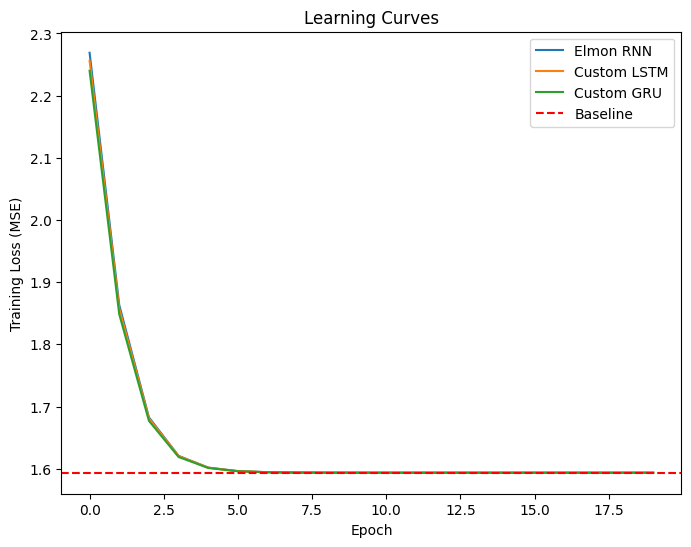

In [116]:
plt.figure(figsize=(8,6))
plt.plot(elmon_losses, label="Elmon RNN")
plt.plot(lstm_losses, label="Custom LSTM")
plt.plot(gru_losses, label="Custom GRU")
plt.axhline(y=baseline_loss, color='r', linestyle='--', label="Baseline")
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Learning Curves")
plt.legend()
plt.show()

##### Dataset with Labels

In [115]:
for i in range(5):
  print(data[i])

('sed for std::memcopy\n#include <iostream>   /// Used for IO operations\n#include <string>     /// Us', 2)
('      std::swap(arr[index], arr[index - 1]);  // swa', 3)
('m_index + 1];\n    }\n\n    /**\n     * @brief Get next node which is possibly contain', 0)
('E INCLUDING ALL IMPLIED\nWARRANTIES OF MERCHANTABILITY AND FITNESS. IN NO EV', 0)
('\n\n        /* The follosing can also be used\n        for (int j = 0; j < 3; j++)\n', 0)


##### Predictions

In [117]:
print("\nElmon RNN Predictions:")
show_sample_predictions(elmon_model, test_data, ind_to_char, num_samples = 100)
print("\nCustom LSTM Predictions:")
show_sample_predictions(lstm_model, test_data, ind_to_char,  num_samples = 100)
print("\nCustom GRU Predictions:")
show_sample_predictions(gru_model, test_data, ind_to_char,  num_samples = 100)


Elmon RNN Predictions:

Sample predictions:
actual:1, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:1, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:5, predicted: 0.98
------------------------------
actual:1, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:1, predicted: 0.98
------------------------------
actual:2, predicted: 0.98
------------------------------
actual:1, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
------------------------------
actual:0, predicted: 0.98
-----------------

## One Hot Encoding + Xavier Initialization

In [123]:
def custom_sigmoid(x):
    x_clipped = torch.clamp(x, min=-1000000, max=1000000)
    exp_neg_x = torch.exp(-x_clipped)
    return 1 / (1 + exp_neg_x)

def custom_tanh(x):
    x_clipped = torch.clamp(x, min=-1000000, max=1000000)
    exp_x = torch.exp(x_clipped)
    exp_neg_x = torch.exp(-x_clipped)
    return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)

### Elmon RNN

Epoch 1/30, Loss: 1.7414
Epoch 2/30, Loss: 1.6718
Epoch 3/30, Loss: 1.6695
Epoch 4/30, Loss: 1.6683
Epoch 5/30, Loss: 1.6674
Epoch 6/30, Loss: 1.6667
Epoch 7/30, Loss: 1.6661
Epoch 8/30, Loss: 1.6657
Epoch 9/30, Loss: 1.6652
Epoch 10/30, Loss: 1.6648
Epoch 11/30, Loss: 1.6644
Epoch 12/30, Loss: 1.6640
Epoch 13/30, Loss: 1.6637
Epoch 14/30, Loss: 1.6633
Epoch 15/30, Loss: 1.6630
Epoch 16/30, Loss: 1.6626
Epoch 17/30, Loss: 1.6623
Epoch 18/30, Loss: 1.6619
Epoch 19/30, Loss: 1.6615
Epoch 20/30, Loss: 1.6611
Epoch 21/30, Loss: 1.6607
Epoch 22/30, Loss: 1.6603
Epoch 23/30, Loss: 1.6599
Epoch 24/30, Loss: 1.6594
Epoch 25/30, Loss: 1.6589
Epoch 26/30, Loss: 1.6584
Epoch 27/30, Loss: 1.6578
Epoch 28/30, Loss: 1.6572
Epoch 29/30, Loss: 1.6565
Epoch 30/30, Loss: 1.6557


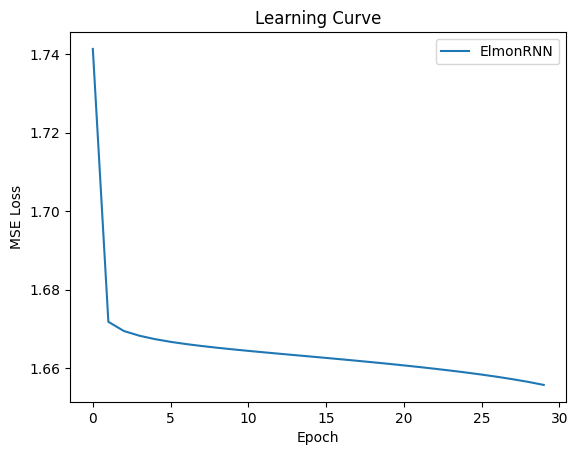


Testing some sample sequences:
Sequence 1: True Label: 1, Predicted: 1.0201
Sequence 2: True Label: 0, Predicted: 1.2158
Sequence 3: True Label: 2, Predicted: 1.1277
Sequence 4: True Label: 1, Predicted: 0.8166
Sequence 5: True Label: 0, Predicted: 1.2371


In [129]:
import csv
import random
import torch
import math
import matplotlib.pyplot as plt

def load_data(csv_file): # Load data
    data = []
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.append((row['X'], int(row['y'])))
    return data

def build_vocab(data): # Sort data to keep the order of characters while encoding
    all_chars = set()
    for seq, _ in data:
        all_chars.update(seq)
    return sorted(list(all_chars))

def one_hot_encode(seq, char_to_idx, vocab_size): # One hot encoding instead of index encoding
    seq_len = len(seq)
    one_hot = torch.zeros(seq_len, vocab_size)
    for i, char in enumerate(seq):
        one_hot[i, char_to_idx[char]] = 1.0
    return one_hot

def get_batches(encoded_data, batch_size, shuffle=True): # Batches of one hot encoded vectors
    if shuffle:
        random.shuffle(encoded_data)
    batches = []
    for i in range(0, len(encoded_data), batch_size):
        batch = encoded_data[i:i+batch_size]
        max_len = max(seq.shape[0] for seq, _ in batch)
        vocab_size = batch[0][0].shape[1]
        batch_inputs, batch_lengths, batch_targets = [], [], []
        for seq, label in batch:
            seq_len = seq.shape[0]
            batch_lengths.append(seq_len)
            padded = torch.zeros(max_len, vocab_size) # Padding
            padded[:seq_len] = seq
            batch_inputs.append(padded)
            batch_targets.append(label) # Labels
        batch_inputs = torch.stack(batch_inputs)
        batch_lengths = torch.tensor(batch_lengths, dtype=torch.long)
        batch_targets = torch.tensor(batch_targets, dtype=torch.float)
        batches.append((batch_inputs, batch_lengths, batch_targets))
    return batches

class ElmonRNN(nn.Module):
    def __init__(self, vocab, embedding_dim, hidden_dim, output_dim):
        super(ElmonRNN, self).__init__()
        self.vocab_size = len(vocab)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        def xavier_uniform_(shape): # Xavier or Glorot Initialization
            fan_in, fan_out = shape[1], shape[0]
            bound = torch.sqrt(torch.tensor(6.0)) / torch.sqrt(torch.tensor(fan_in + fan_out))
            return torch.empty(shape).uniform_(-bound, bound)

        # Apply Xavier Initialization & Bias Initialization (1 * 0.1)
        self.E = torch.nn.Parameter(xavier_uniform_((self.vocab_size, embedding_dim)))
        self.Wxh = torch.nn.Parameter(xavier_uniform_((embedding_dim, hidden_dim)))
        self.Whh = torch.nn.Parameter(xavier_uniform_((hidden_dim, hidden_dim)))
        self.bh = torch.nn.Parameter(torch.ones(hidden_dim) * 0.1)

        self.Why = torch.nn.Parameter(xavier_uniform_((hidden_dim, output_dim)))
        self.by = torch.nn.Parameter(torch.ones(output_dim) * 0.1)

        self.params = [self.E, self.Wxh, self.Whh, self.bh, self.Why, self.by]

    def forward(self, inputs, lengths):
        batch_size, seq_len, _ = inputs.shape
        embedded = torch.matmul(inputs, self.E)  # (batch_size, seq_len, embedding_dim)
        h = torch.zeros(batch_size, self.hidden_dim)
        for t in range(seq_len):
            xt = embedded[:, t, :]
            h = custom_tanh(xt @ self.Wxh + h @ self.Whh + self.bh)
        out = h @ self.Why + self.by
        return out

    def parameters(self):
        return self.params

def mse_loss(preds, targets): # Loss function
    return ((preds.squeeze() - targets) ** 2).mean()

def clip_gradients(model, max_norm):  # To avoid gradient explotion
    total_norm = 0
    for param in model.parameters():
        if param.grad is not None:
            total_norm += param.grad.data.norm(2).item() ** 2
    total_norm = math.sqrt(total_norm)
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.mul_(max_norm / (total_norm + 1e-6))

def train_model(model, batches, lr, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, lengths, targets in batches:
            preds = model.forward(inputs, lengths) # forward pass
            loss = mse_loss(preds, targets)
            epoch_loss += loss.item()
            loss.backward() # back prop
            clip_gradients(model, max_norm=1.0)
            for param in model.parameters():
                if param.grad is not None:
                    param.data -= lr * param.grad.data # Update parameters
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.zero_() # Clear Gradient
        avg_loss = epoch_loss / len(batches) # Loss eestimation
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return losses

# Load and process the dataset
csv_file = "/content/balanced_brackets_dataset.csv"
data = load_data(csv_file)
vocab = build_vocab(data)
char_to_idx = {char: i for i, char in enumerate(vocab)}
one_hot_data = [(one_hot_encode(seq, char_to_idx, len(vocab)), label) for seq, label in data]
batches = get_batches(one_hot_data, batch_size=32, shuffle=True)

embedding_dim = 50
hidden_dim = 50
output_dim = 1
elmon_model = ElmonRNN(vocab, embedding_dim, hidden_dim, output_dim)

lr = 0.001
num_epochs = 30
elmon_losses = train_model(elmon_model, batches, lr, num_epochs)

# Loss Curve
plt.plot(elmon_losses, label="ElmonRNN")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

# Testing some values
print("\nTesting some sample sequences:")
test_cases = one_hot_data[:5]
for i, (seq, true_label) in enumerate(test_cases):
    input_tensor = seq.unsqueeze(0)  # Add batch dimension
    prediction = elmon_model(input_tensor, 1)
    print(f"Sequence {i+1}: True Label: {true_label}, Predicted: {prediction.item():.4f}")

### LSTM

Epoch 1/30, Loss: 1.5188
Epoch 2/30, Loss: 0.5752
Epoch 3/30, Loss: 0.4517
Epoch 4/30, Loss: 0.4516
Epoch 5/30, Loss: 0.3892
Epoch 6/30, Loss: 0.3592
Epoch 7/30, Loss: 0.3395
Epoch 8/30, Loss: 0.3530
Epoch 9/30, Loss: 0.3084
Epoch 10/30, Loss: 0.2988
Epoch 11/30, Loss: 0.3013
Epoch 12/30, Loss: 0.2891
Epoch 13/30, Loss: 0.3197
Epoch 14/30, Loss: 0.2552
Epoch 15/30, Loss: 0.2108
Epoch 16/30, Loss: 0.2145
Epoch 17/30, Loss: 0.2060
Epoch 18/30, Loss: 0.1995
Epoch 19/30, Loss: 0.1810
Epoch 20/30, Loss: 0.1664
Epoch 21/30, Loss: 0.2004
Epoch 22/30, Loss: 0.2263
Epoch 23/30, Loss: 0.2046
Epoch 24/30, Loss: 0.1673
Epoch 25/30, Loss: 0.1558
Epoch 26/30, Loss: 0.1447
Epoch 27/30, Loss: 0.1553
Epoch 28/30, Loss: 0.2409
Epoch 29/30, Loss: 0.1648
Epoch 30/30, Loss: 0.1310


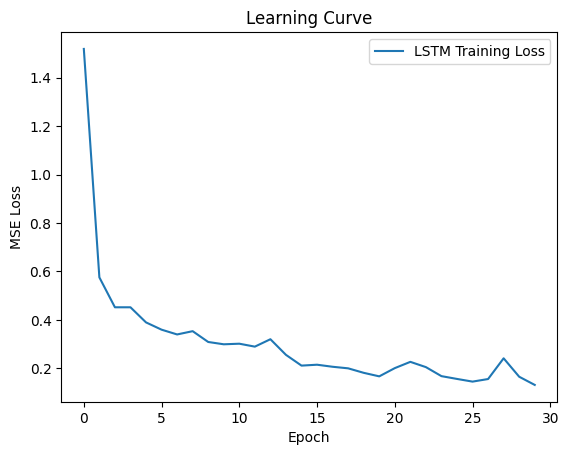


Testing some sample sequences:
Sequence 1: True Label: 0, Predicted: 0.2495
Sequence 2: True Label: 1, Predicted: 0.5787
Sequence 3: True Label: 0, Predicted: -0.3011
Sequence 4: True Label: 1, Predicted: -0.0591
Sequence 5: True Label: 4, Predicted: 3.9228


In [125]:
import csv
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


def load_data(csv_file):
    data = []
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.append((row['X'], int(row['y'])))
    return data

def build_vocab(data):
    all_chars = set()
    for seq, _ in data:
        all_chars.update(seq)
    return sorted(list(all_chars))

def one_hot_encode(seq, char_to_idx, vocab_size):
    seq_len = len(seq)
    one_hot = torch.zeros(seq_len, vocab_size)
    for i, char in enumerate(seq):
        one_hot[i, char_to_idx[char]] = 1.0
    return one_hot

def get_batches(encoded_data, batch_size, shuffle=True):
    if shuffle:
        random.shuffle(encoded_data)
    batches = []
    for i in range(0, len(encoded_data), batch_size):
        batch = encoded_data[i:i+batch_size]
        max_len = max(seq.shape[0] for seq, _ in batch)
        vocab_size = batch[0][0].shape[1]
        batch_inputs, batch_lengths, batch_targets = [], [], []
        for seq, label in batch:
            seq_len = seq.shape[0]
            batch_lengths.append(seq_len)
            padded = torch.zeros(max_len, vocab_size)
            padded[:seq_len] = seq
            batch_inputs.append(padded)
            batch_targets.append(label)
        batch_inputs = torch.stack(batch_inputs)
        batch_lengths = torch.tensor(batch_lengths, dtype=torch.long)
        batch_targets = torch.tensor(batch_targets, dtype=torch.float)
        batches.append((batch_inputs, batch_lengths, batch_targets))
    return batches

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size

        def xavier_uniform_(shape):
            fan_in, fan_out = shape[1], shape[0]
            bound = torch.sqrt(torch.tensor(6.0)) / torch.sqrt(torch.tensor(fan_in + fan_out))
            return nn.Parameter(torch.empty(shape).uniform_(-bound, bound))

        # Apply Xavier Initialisation & Bias to a non zero value
        self.W_f = xavier_uniform_((hidden_size, input_size))
        self.U_f = xavier_uniform_((hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.ones(hidden_size) * 0.1)

        self.W_i = xavier_uniform_((hidden_size, input_size))
        self.U_i = xavier_uniform_((hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.ones(hidden_size) * 0.1)

        self.W_o = xavier_uniform_((hidden_size, input_size))
        self.U_o = xavier_uniform_((hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.ones(hidden_size) * 0.1)

        self.W_c = xavier_uniform_((hidden_size, input_size))
        self.U_c = xavier_uniform_((hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.W_y = xavier_uniform_((output_size, hidden_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h_t = torch.zeros(batch_size, self.hidden_size)
        c_t = torch.zeros(batch_size, self.hidden_size)

        for t in range(seq_len):
            # lstm eqns
            x_t = x[:, t, :]
            f_t = custom_sigmoid(torch.matmul(x_t, self.W_f.T) + torch.matmul(h_t, self.U_f.T) + self.b_f)
            i_t = custom_sigmoid(torch.matmul(x_t, self.W_i.T) + torch.matmul(h_t, self.U_i.T) + self.b_i)
            o_t = custom_sigmoid(torch.matmul(x_t, self.W_o.T) + torch.matmul(h_t, self.U_o.T) + self.b_o)
            g_t = custom_tanh(torch.matmul(x_t, self.W_c.T) + torch.matmul(h_t, self.U_c.T) + self.b_c)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * custom_tanh(c_t)

        logits = torch.matmul(h_t, self.W_y.T) + self.b_y
        return logits.squeeze(1)

def mse_loss(preds, targets):
    return ((preds.squeeze() - targets) ** 2).mean()

def train_model(model, batches, lr, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Optmizer added to reduce loss

    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, lengths, targets in batches:
            preds = model(inputs)
            loss = mse_loss(preds, targets) # Loss estimation
            epoch_loss += loss.item()
            optimizer.zero_grad() # clear grad
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(batches)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return losses

csv_file = "/content/balanced_brackets_dataset.csv"
data = load_data(csv_file)
vocab = build_vocab(data)
char_to_idx = {char: i for i, char in enumerate(vocab)}
one_hot_data = [(one_hot_encode(seq, char_to_idx, len(vocab)), label) for seq, label in data]
batches = get_batches(one_hot_data, batch_size=32, shuffle=True)

embedding_dim = len(vocab)
hidden_dim = 50
output_dim = 1
lstm_model = CustomLSTM(embedding_dim, hidden_dim, output_dim)
lr = 0.001
num_epochs = 30
lstm_losses = train_model(lstm_model, batches, lr, num_epochs)

# Plot loss curve
plt.plot(lstm_losses, label="LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

# Test some values
print("\nTesting some sample sequences:")
test_cases = one_hot_data[:5]
for i, (seq, true_label) in enumerate(test_cases):
    input_tensor = seq.unsqueeze(0)  # Add batch dimension
    prediction = lstm_model(input_tensor)
    print(f"Sequence {i+1}: True Label: {true_label}, Predicted: {prediction.item():.4f}")

### GRU

Epoch 1/30, Loss: 1.6625
Epoch 2/30, Loss: 0.8732
Epoch 3/30, Loss: 0.4075
Epoch 4/30, Loss: 0.3345
Epoch 5/30, Loss: 0.2946
Epoch 6/30, Loss: 0.2631
Epoch 7/30, Loss: 0.2351
Epoch 8/30, Loss: 0.2128
Epoch 9/30, Loss: 0.1933
Epoch 10/30, Loss: 0.1762
Epoch 11/30, Loss: 0.1612
Epoch 12/30, Loss: 0.1462
Epoch 13/30, Loss: 0.1326
Epoch 14/30, Loss: 0.1241
Epoch 15/30, Loss: 0.1194
Epoch 16/30, Loss: 0.1129
Epoch 17/30, Loss: 0.1069
Epoch 18/30, Loss: 0.0989
Epoch 19/30, Loss: 0.0955
Epoch 20/30, Loss: 0.0862
Epoch 21/30, Loss: 0.0932
Epoch 22/30, Loss: 0.0903
Epoch 23/30, Loss: 0.0778
Epoch 24/30, Loss: 0.0818
Epoch 25/30, Loss: 0.0729
Epoch 26/30, Loss: 0.0674
Epoch 27/30, Loss: 0.0635
Epoch 28/30, Loss: 0.0797
Epoch 29/30, Loss: 0.0607
Epoch 30/30, Loss: 0.0583


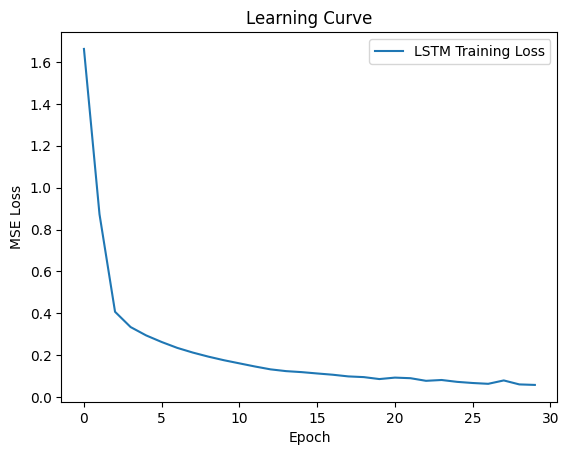


Testing some sample sequences:
Sequence 1: True Label: 2, Predicted: 2.2966
Sequence 2: True Label: 1, Predicted: 1.0068
Sequence 3: True Label: 4, Predicted: 4.2821
Sequence 4: True Label: 0, Predicted: 0.0402
Sequence 5: True Label: 3, Predicted: 3.1754


In [126]:
import csv
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def load_data(csv_file):
    data = []
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.append((row['X'], int(row['y'])))
    return data

def build_vocab(data):
    all_chars = set()
    for seq, _ in data:
        all_chars.update(seq)
    return sorted(list(all_chars))

def one_hot_encode(seq, char_to_idx, vocab_size):
    seq_len = len(seq)
    one_hot = torch.zeros(seq_len, vocab_size)
    for i, char in enumerate(seq):
        one_hot[i, char_to_idx[char]] = 1.0
    return one_hot

def get_batches(encoded_data, batch_size, shuffle=True):
    if shuffle:
        random.shuffle(encoded_data)
    batches = []
    for i in range(0, len(encoded_data), batch_size):
        batch = encoded_data[i:i+batch_size]
        max_len = max(seq.shape[0] for seq, _ in batch)
        vocab_size = batch[0][0].shape[1]
        batch_inputs, batch_lengths, batch_targets = [], [], []
        for seq, label in batch:
            seq_len = seq.shape[0]
            batch_lengths.append(seq_len)
            padded = torch.zeros(max_len, vocab_size)
            padded[:seq_len] = seq
            batch_inputs.append(padded)
            batch_targets.append(label)
        batch_inputs = torch.stack(batch_inputs)
        batch_lengths = torch.tensor(batch_lengths, dtype=torch.long)
        batch_targets = torch.tensor(batch_targets, dtype=torch.float)
        batches.append((batch_inputs, batch_lengths, batch_targets))
    return batches

class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomGRU, self).__init__()
        self.hidden_size = hidden_size

        def xavier_uniform_(shape):
            fan_in, fan_out = shape[1], shape[0]
            bound = torch.sqrt(torch.tensor(6.0)) / torch.sqrt(torch.tensor(fan_in + fan_out))
            return nn.Parameter(torch.empty(shape).uniform_(-bound, bound))

        # Bias value set to non zero and Xavier Initialization of weights
        self.Wxr = xavier_uniform_((hidden_size, input_size))
        self.Whr = xavier_uniform_((hidden_size, hidden_size))
        self.br = nn.Parameter(torch.ones(hidden_size) * 0.1)

        self.Wxz = xavier_uniform_((hidden_size, input_size))
        self.Whz = xavier_uniform_((hidden_size, hidden_size))
        self.bz = nn.Parameter(torch.ones(hidden_size) * 0.1)

        self.Wxh = xavier_uniform_((hidden_size, input_size))
        self.Whh = xavier_uniform_((hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.ones(hidden_size) * 0.1)

        self.W_y = xavier_uniform_((output_size, hidden_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        for t in range(seq_len):
            # eqns of gru
            x_t = x[:, t, :]
            # r gate
            r_t = custom_sigmoid(torch.matmul(x_t, self.Wxr.T) + torch.matmul(h_t, self.Whr.T) + self.br)
            # z gate
            z_t = custom_sigmoid(torch.matmul(x_t, self.Wxz.T) + torch.matmul(h_t, self.Whz.T) + self.bz)
            h_ = custom_tanh(torch.matmul(x_t, self.Wxh.T) + torch.matmul(r_t * h_t, self.Whh.T) + self.bh)
            h_t = (1 - z_t) * h_t + z_t * h_
        logits = torch.matmul(h_t, self.W_y.T) + self.b_y
        return logits.squeeze(1)

def mse_loss(preds, targets):
    return ((preds.squeeze() - targets) ** 2).mean()

def train_model(model, batches, lr, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer added to reduce loss

    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, lengths, targets in batches:
            preds = model(inputs)
            loss = mse_loss(preds, targets)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(batches)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return losses

csv_file = "/content/balanced_brackets_dataset.csv"
data = load_data(csv_file)
vocab = build_vocab(data)
char_to_idx = {char: i for i, char in enumerate(vocab)}
one_hot_data = [(one_hot_encode(seq, char_to_idx, len(vocab)), label) for seq, label in data]
batches = get_batches(one_hot_data, batch_size=32, shuffle=True)

embedding_dim = len(vocab)
hidden_dim = 50
output_dim = 1
gru_model = CustomGRU(embedding_dim, hidden_dim, output_dim)
lr = 0.001
num_epochs = 30
gru_losses = train_model(gru_model, batches, lr, num_epochs)

# Plot loss curve
plt.plot(gru_losses, label="LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

# Test some values
print("\nTesting some sample sequences:")
test_cases = one_hot_data[:5]
for i, (seq, true_label) in enumerate(test_cases):
    input_tensor = seq.unsqueeze(0)  # Add batch dimension
    prediction = gru_model(input_tensor)
    print(f"Sequence {i+1}: True Label: {true_label}, Predicted: {prediction.item():.4f}")

##### Combined Loss Curve

In [127]:
baseline_loss, _, _ = evaluate_model(baseline_model, batches)

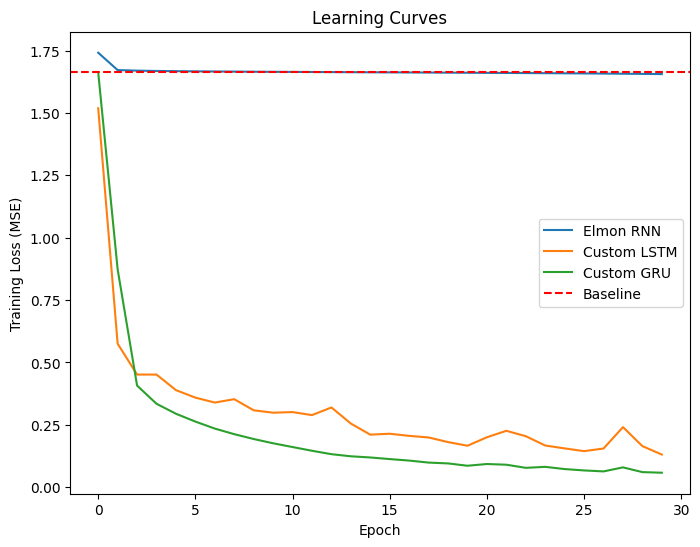

In [130]:
plt.figure(figsize=(8,6))
plt.plot(elmon_losses, label="Elmon RNN")
plt.plot(lstm_losses, label="Custom LSTM")
plt.plot(gru_losses, label="Custom GRU")
plt.axhline(y=baseline_loss, color='r', linestyle='--', label="Baseline")
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Learning Curves")
plt.legend()
plt.show()

In [137]:
import torch

def one_hot_encode_string(input_string, char_to_idx, vocab_size):
    seq_len = len(input_string)
    one_hot = torch.zeros(seq_len, vocab_size)
    for i, char in enumerate(input_string):
        if char in char_to_idx:
            one_hot[i, char_to_idx[char]] = 1.0  # One-hot encoding
        else:
            print(f"Warning: Character '{char}' not in vocabulary, ignoring it.")
    return one_hot

input_string = "int main<>"

one_hot_input = one_hot_encode_string(input_string, char_to_idx, len(vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
one_hot_input = one_hot_input.unsqueeze(0).to(device)

with torch.no_grad():
    prediction = torch.round(elmon_model(one_hot_input, 1)).cpu().item()
    # prediction = torch.round(lstm_model(one_hot_input)).cpu().item()
    # prediction = torch.round(gru_model(one_hot_input)).cpu().item()

print(f"\nInput String: {input_string}")
print(f"Predicted Balanced Brackets Count: {prediction:.4f}")


Input String: int main<>
Predicted Balanced Brackets Count: 1.0000
